# Facebook Social Circles V2
Link: https://snap.stanford.edu/data/ego-Facebook.html

>This dataset consists of 'circles' (or 'friends lists') from Facebook. Facebook data was collected from survey participants using this Facebook app.

---

Focus: Integrating node-level features with scaled Logistic Regression; optimizing via basic hyperparameter tuning.

In [ ]:
# Imports
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import time
import sys
sys.path.append('../')

from utils import negative_sampling as ns, splits, plot

from sklearn.linear_model import LogisticRegression

## Dataset Loading

This dataset is an ego network, meaning that it centers around a specific user (the "ego") and includes all their immediate friends and the connections between those friends.
There are several file types:
- `.edges`: These files define the edges within a specific ego network.
- `.feat`: These files contain anonymized binary features for all nodes in the ego network (except the ego itself). Each line starts with a node ID, followed by a series of binary (0 or 1) feature values, space-separated.
- `.egofeat`: These files contain the anonymized binary features for the ego node itself.
- `.featnames`: Provides a mapping for the feature indices. Each line describes a feature. Due to anonymization, the descriptions are generic.
- `.circles`: Defines "circles" or "friend lists" within the ego network (ground-truth communities). Each line starts with a label, followed by a list of space-separated node IDs that belong to that circle. 

For learning purposes this notebook will focus on just one ego network (of node `0`) from all the ego networks available in the dataset.

In [23]:
# Load Graph
G = nx.read_edgelist('data/0.edges', nodetype=int)

In [ ]:
# Load Features Names
feature_path = 'data/0.feat'
feature_names_path = 'data/0.featnames'
egofeat_path = "data/0.egofeat"

feature_names = []
try:
    with open(feature_names_path, 'r') as f:
        for line in f:
            line = line.strip()
            parts = line.split(' ', 1)  # Separate indexes
            feature_names.append(parts[1])
except Exception as e:
    print(f"An error occurred while loading feature names: {e}")
    feature_names = []

feature_names[:10]

['birthday;anonymized feature 0',
 'birthday;anonymized feature 1',
 'birthday;anonymized feature 2',
 'birthday;anonymized feature 3',
 'birthday;anonymized feature 4',
 'birthday;anonymized feature 5',
 'birthday;anonymized feature 6',
 'birthday;anonymized feature 7',
 'education;classes;id;anonymized feature 8',
 'education;classes;id;anonymized feature 9']

Feature vectors from this dataset has been obscured, so each feature real value has been replaced. For instance, a feature "political=Democratic Party", would be replaced with "political=anonymized feature 1".

In [54]:
# Load Features Values
node_ids = []
feature_data_rows = []
expected_num_features = len(feature_names)

try:
    with open(feature_path, 'r') as f:
        for line in f:
            line = line.strip()
            parts = line.split(' ')

            node_id = int(parts[0])

            feat_values = [int(val) for val in parts[1:]]

            node_ids.append(node_id)
            feature_data_rows.append(feat_values)

except Exception as e:
    print(f"An error occurred while loading feature data: {e}")

# Create Dataframe
features_df = pd.DataFrame(feature_data_rows, columns=feature_names, index=node_ids)
features_df.head(10)

,birthday;anonymized feature 0,birthday;anonymized feature 1,birthday;anonymized feature 2,birthday;anonymized feature 3,birthday;anonymized feature 4,birthday;anonymized feature 5,birthday;anonymized feature 6,birthday;anonymized feature 7,education;classes;id;anonymized feature 8,education;classes;id;anonymized feature 9,...,work;start_date;anonymized feature 200,work;start_date;anonymized feature 201,work;start_date;anonymized feature 168,work;start_date;anonymized feature 202,work;start_date;anonymized feature 169,work;start_date;anonymized feature 170,work;start_date;anonymized feature 171,work;start_date;anonymized feature 203,work;start_date;anonymized feature 204,work;with;id;anonymized feature 205
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


The features DataFrame utilizes **one-hot encoding**, a technique used to represent categorical variables as binary vectors. This method converts each distinct category into a binary feature: a '1' indicates the presence of that category, while all other related elements are '0'.

Occasionally, for a specific class of features, such as "birthday," a node might exhibit all zeros across its categorical values. The most straightforward explanation for this is simply that the information for that particular user was either unavailable or not provided in the dataset.

While columns representing the same feature class could be merged into a single column with multiple categorical values (e.g., birthday='6'), which would improve *human readability*, this approach presents drawbacks for Logistic Regression models. These models require *numerical input*, such as binary values. Converting to distinct, non-ordered categories would cause the model to mistakenly interpret a value like '7' as "greater" than '0' (e.g., birthday 7 as superior to birthday 0), despite the dataset not specifying any **ordinal relationship between categories**.

Consequently, the DataFrame is maintained in its current one-hot encoded format. The primary drawback of this approach is an **increased dimensionality**, but it ensures the data is optimally prepared for logistic regression tasks.

## Exploratory Data Analysis (EDA)

### Graph Topology

In [57]:
density = nx.density(G)

print(G)
print(f'Average degree: {sum(dict(G.degree).values()) / len(G.nodes):.1f}')
print(f'Max degree: {max(dict(G.degree).values())}')
print(f'Min degree: {min(dict(G.degree).values())}')
print(f'Density: {density:.4f}')

Graph with 333 nodes and 2519 edges
Average degree: 15.1
Max degree: 77
Min degree: 1
Density: 0.0456


---

In [ ]:
# Connected Components
print("Number of connected components:", nx.number_connected_components(G))

G_lcc = G.subgraph(max(nx.connected_components(G), key=len)).copy()
print("Largest Connected Component:", G_lcc)

Number of connected components: 5
Largest Connected Component: Graph with 324 nodes and 2514 edges


This is an interesting result: I initially supposed that in an ego network there would have been a single connected component, while i actually found five. After further investigation i found that in the readme file provided with the dataset is specified that the ego node is removed from the ego graph. This seems to be common in ego networks: by definition the central ego node is always connected to all of its direct friends and there is no need to to explicitly list all its edges.

This changes the goal of the prediction task to identifying potential new or missing connections between pairs of the ego's friends who are not currently connected.

---

In [66]:
# Clustering
print(f'Average Local Clustering: {nx.average_clustering(G):.4f}')
print(f'Transitivity: {nx.transitivity(G):.4f}')

Average Local Clustering: 0.5082
Transitivity: 0.4259


---

In [67]:
# Distances
print(f'Average Shortest Path Length in the LCC: {nx.average_shortest_path_length(G_lcc):.2f}')
print('Diameter of LCC:', nx.diameter(G_lcc))

Average Shortest Path Length in the LCC: 3.75
Diameter of LCC: 11


This two values are probably much higher with the ego node removed.

---

#### Degree Distribution Analysis
Looking at the degree distribution, we can make hypotheses on the performance of the Preferential Attachment measure for link prediction.

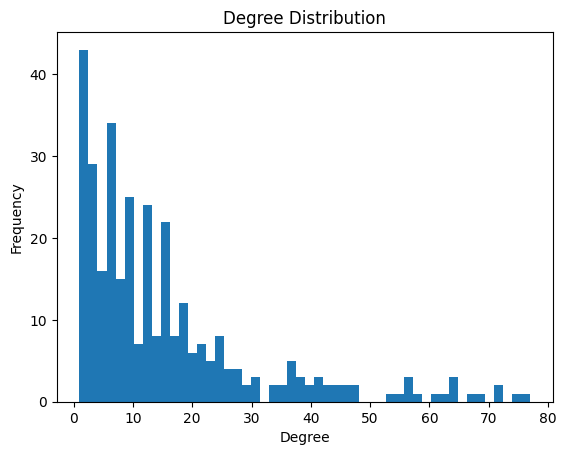

In [68]:
#Linear Scale Histogram
plot.degree_count_plot(G_lcc, logy=False)

### Node Features